# Comparing  old and new feature generation functions to ensure identical results

In [1]:
import spock
import random
import numpy as np
import rebound
import pandas as pd
from spock import simsetup
from spock import FeatureKlassifier
from spock import FeatureClassifier

We can load initial conditions from our system dataset as REBOUND simulations

we will look at a subset of the resonant systems to ensure compatibility

In [2]:
#specify the data path
datapath = '../cleanData/csvs/resonant/clean_initial_conditions.csv'
initial = pd.read_csv(datapath)
#drop junk column
initial = initial.drop('Unnamed: 0', axis = 1)
initial.head()

,p0m,p0x,p0y,p0z,p0vx,p0vy,p0vz,p1m,p1x,p1y,...,p2vy,p2vz,p3m,p3x,p3y,p3z,p3vx,p3vy,p3vz,runstring
0,0.999996,0.000007,-0.000018,1.269113e-07,0.000059,0.000031,-7.653712e-08,3.984920e-06,-0.982960,-0.183683,...,-0.437075,-0.002895,2.531702e-07,-1.288724,0.962201,-0.018973,-3.077432,-3.851732,-0.164377,0000000.bin
1,1.000000,-0.000020,0.000003,-3.832419e-07,-0.000015,-0.000092,2.664138e-06,2.065557e-07,0.845257,-0.535312,...,5.610770,-0.157725,6.830431e-07,-1.327142,0.550229,-0.009861,-1.680953,-4.761961,-0.052477,0000001.bin
2,1.000000,0.000057,-0.000215,-1.197840e-06,0.000394,0.000225,1.018178e-06,1.797281e-07,0.899352,-0.407481,...,-5.756639,0.019097,9.648477e-05,-0.208863,2.258035,0.009349,-4.143923,-0.430091,-0.016918,0000002.bin
3,0.999953,0.000071,0.000045,2.256372e-06,-0.000199,0.000297,-1.334874e-06,4.704418e-05,-0.819392,-0.685703,...,-0.179467,0.045955,1.615758e-05,-2.003066,-0.132781,-0.004192,0.293880,-4.423427,0.115038,0000003.bin
4,0.999996,-0.000063,0.000013,1.256863e-06,-0.000045,-0.000265,-3.323176e-06,3.514145e-06,0.865534,0.497927,...,0.668516,0.002231,4.655600e-05,1.292557,-0.324317,-0.026652,1.326032,5.277415,0.076018,0000004.bin


We can establish a function that, given a list of initial conditions, will return a rebound simulation

In [3]:
def get_sim(row, dataset):
    '''Given a row number, and a data sheet containing initial conditions, returns a corresponding simulation
    
        Arguments:
            row: what row the simulation you would like to create is on
                format of row is in order: 
                [index, 'p0m', 'p0x', 'p0y', 'p0z', 'p0vx', 'p0vy', 'p0vz', 'p1m', 'p1x', 'p1y',
                'p1z', 'p1vx', 'p1vy', 'p1vz', 'p2m', 'p2x', 'p2y', 'p2z', 'p2vx',
                'p2vy', 'p2vz', 'p3m', 'p3x', 'p3y', 'p3z', 'p3vx', 'p3vy', 'p3vz']

            dataset: what dataset contains your initial conditions

        return: returns a rebound simulation with the specified initial conditions'''
    try:
        data = dataset.loc[row]
        sim = rebound.Simulation()
        sim.G=4*np.pi**2
        sim.add(m=data['p0m'], x=data['p0x'], y=data['p0y'], z=data['p0z'], vx=data['p0vx'], vy=data['p0vy'], vz=data['p0vz'])
        sim.add(m=data['p1m'], x=data['p1x'], y=data['p1y'], z=data['p1z'], vx=data['p1vx'], vy=data['p1vy'], vz=data['p1vz'])
        sim.add(m=data['p2m'], x=data['p2x'], y=data['p2y'], z=data['p2z'], vx=data['p2vx'], vy=data['p2vy'], vz=data['p2vz'])
        sim.add(m=data['p3m'], x=data['p3x'], y=data['p3y'], z=data['p3z'], vx=data['p3vx'], vy=data['p3vy'], vz=data['p3vz'])
        #sets dt and com
        #simsetup.init_sim_parameters(sim)
        return sim
    except:
        print("Error reading initial condition {0}".format(row))
        return None

We can now randomly sample 1000 simulations to compare

In [4]:
#generates the indexes of the systems
systemNum = range(100)
#creates the set of simulations
simSet = list(map((lambda i: get_sim(i,initial)),systemNum))

In [5]:
col = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear', 'EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'MEGNO', 'MEGNOstd']

In [6]:
new = FeatureKlassifier()
old = FeatureClassifier()

In [7]:
newMeth = pd.DataFrame(np.array(list(map((lambda sim: list(new.generate_features(sim)[0][0].values())),simSet))), columns=col)
oldMeth = pd.DataFrame(np.array(list(map((lambda sim: list(old.generate_features(sim)[0][0].values())),simSet))), columns=col)


In [8]:
tn = newMeth
to = oldMeth

In [9]:
tn.describe()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd
count,100.000000,98.000000,98.000000,97.000000,100.000000,98.000000,98.000000,81.000000,98.000000,98.000000
mean,0.145956,0.068543,0.003331,0.570853,0.337345,0.034853,0.004218,0.253476,18.598728,4.706194
std,0.099509,0.088559,0.005085,1.207604,0.198329,0.040620,0.005649,0.579168,41.679732,12.533936
min,0.029429,0.008093,0.000027,0.010592,0.052128,0.000498,0.000014,0.000548,1.671791,0.000261
25%,0.069049,0.019081,0.000507,0.044956,0.182161,0.008262,0.000410,0.013724,1.994905,0.018492
50%,0.123119,0.037916,0.001015,0.145387,0.281119,0.021261,0.001983,0.036284,2.722397,0.271722
75%,0.193235,0.070644,0.003548,0.519172,0.473268,0.043226,0.005906,0.117980,17.578018,3.792554
max,0.589032,0.549971,0.025327,7.959596,1.001981,0.189859,0.030651,3.442084,295.963778,97.901384


In [10]:
test = pd.concat([tn,to])
test['dup'] = pd.concat([tn,to]).duplicated(keep=False)

In [11]:
test

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,dup
0,0.060234,0.015818,0.000309,0.519172,0.504063,0.000734,0.000118,NaN,1.991333,0.003900,True
1,0.080547,0.015760,0.000149,0.411615,0.240504,0.008907,0.002190,0.008154,1.992337,0.004400,True
2,0.129660,0.029638,0.001016,1.004665,1.001981,0.000605,0.001013,0.010432,1.976166,0.017616,True
3,0.406112,0.037044,0.000954,0.270161,0.427768,0.031321,0.003735,0.013724,2.002622,0.000693,True
4,0.059897,0.020438,0.001445,0.207053,0.257596,0.052279,0.001528,0.035104,1.815040,0.082661,True
...,...,...,...,...,...,...,...,...,...,...,...
95,0.248961,0.180636,0.010347,0.160100,0.313106,0.086311,0.001346,0.695376,1.951805,0.157091,True
96,0.251792,0.031922,0.000618,0.169558,0.283201,0.016227,0.000294,0.051882,2.132727,0.056544,True
97,0.138286,0.014832,0.004957,0.040738,0.586498,0.011137,0.002792,1.062896,2.402203,0.193406,True
98,0.168006,0.014622,0.000612,0.049621,0.212054,0.009267,0.001204,1.419807,1.847572,0.161116,True


In [12]:
test = test.drop(test[test['dup']==True].index)


In [13]:
test.describe()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
test

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,dup


29
36
46
50
92

In [15]:
new.generate_features(simSet[29])
#which one is i1 and i2 is changing order is weird 

([OrderedDict([('EMcrossnear', 0.21170605247831437),
               ('EMfracstdnear', 0.008168624486263593),
               ('EPstdnear', 0.0017150524897755763),
               ('MMRstrengthnear', 2.6501845117997673),
               ('EMcrossfar', 0.21504867929535407),
               ('EMfracstdfar', 0.08028582971238954),
               ('EPstdfar', 0.00900691515626038),
               ('MMRstrengthfar', 0.14545096075801986),
               ('MEGNO', 1.6838570005329694),
               ('MEGNOstd', 0.2953952321255718)])],
 True)

In [16]:
old.generate_features(simSet[29])

([OrderedDict([('EMcrossnear', 0.21170605247831437),
               ('EMfracstdnear', 0.008168624486263593),
               ('EPstdnear', 0.0017150524897755763),
               ('MMRstrengthnear', 2.6501845117997673),
               ('EMcrossfar', 0.21504867929535407),
               ('EMfracstdfar', 0.08028582971238954),
               ('EPstdfar', 0.00900691515626038),
               ('MMRstrengthfar', 0.14545096075801986),
               ('MEGNO', 1.6838570005329694),
               ('MEGNOstd', 0.2953952321255718)])],
 True)

In [17]:
test.iloc[2][1]-test.iloc[0][1]

IndexError: single positional indexer is out-of-bounds

In [ ]:
temp = simSet[47]

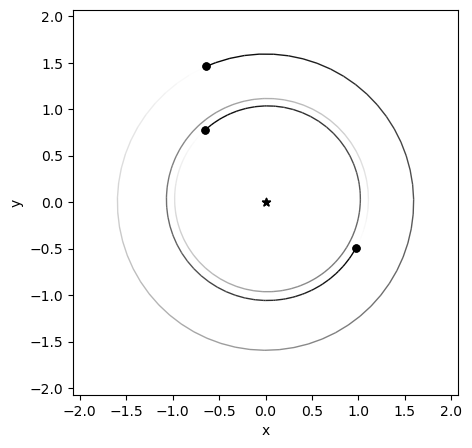

In [ ]:
rebound.OrbitPlot(temp)

In [ ]:
temp.integrate(5e4)

In [ ]:
(np.abs(tn-to)).describe()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd
count,100.0,98.000000,98.000000,97.00000,100.0,98.000000,98.000000,81.000000,98.0,98.0
mean,0.0,0.003858,0.000202,0.01070,0.0,0.005542,0.000244,0.004026,0.0,0.0
std,0.0,0.021942,0.001365,0.07234,0.0,0.033185,0.001924,0.025359,0.0,0.0
min,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
25%,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
50%,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
75%,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
max,0.0,0.180605,0.011899,0.67662,0.0,0.294444,0.018543,0.215245,0.0,0.0


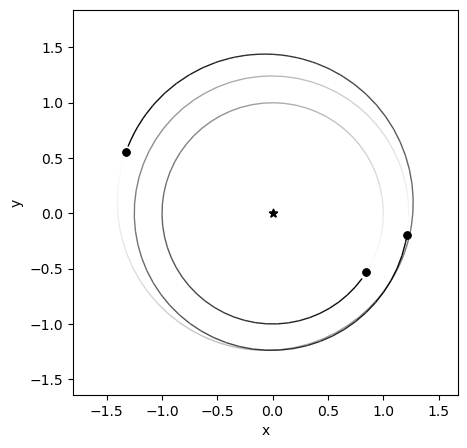

In [ ]:
import rebound
%matplotlib inline

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=3.e-5, P=1., e=0.05, pomega = 2.1, l=0.3)
sim.add(m=3.e-5, P=1.4, e=0.05, pomega = 4.2, l=2.8)
sim.add(m=3.e-5, P=2, e=0.05, pomega = 2.8, l=4.2)
sim.add(m=3.e-5, P=3.5, e=0.05, pomega = 0.3, l=2.1)
sim.move_to_com()
fig = rebound.OrbitPlot(simSet[1])

In [ ]:
new = FeatureKlassifier()

In [ ]:
new.predict_stable(sim)

0.018106783

In [ ]:
new.generate_features(sim)

([OrderedDict([('EMcrossnear', 0.25147746328412046),
               ('EMfracstdnear', 0.0475487304230027),
               ('EPstdnear', 0.012180187464057792),
               ('MMRstrengthnear', 0.588457459240088),
               ('EMcrossfar', 0.2684469716587564),
               ('EMfracstdfar', 0.07986957891321333),
               ('EPstdfar', 0.013071456819904561),
               ('MMRstrengthfar', 0.01574326495322932),
               ('MEGNO', 6.985305292678694),
               ('MEGNOstd', 1.911955633038366)]),
  OrderedDict([('EMcrossnear', 0.2684469716587564),
               ('EMfracstdnear', 0.07986957891321333),
               ('EPstdnear', 0.013071456819904561),
               ('MMRstrengthnear', 0.01574326495322932),
               ('EMcrossfar', 0.4522109539032094),
               ('EMfracstdfar', 0.055276428878115874),
               ('EPstdfar', 0.009091619199734217),
               ('MMRstrengthfar', nan),
               ('MEGNO', 6.985305292678694),
               ('MEGN

In [ ]:
from spock import FeatureClassifier
old = FeatureClassifier()
old.generate_features(sim)

([OrderedDict([('EMcrossnear', 0.25147746328412046),
               ('EMfracstdnear', 0.0475487304230027),
               ('EPstdnear', 0.012180187464057792),
               ('MMRstrengthnear', 0.588457459240088),
               ('EMcrossfar', 0.2684469716587564),
               ('EMfracstdfar', 0.07986957891321333),
               ('EPstdfar', 0.013071456819904561),
               ('MMRstrengthfar', 0.01574326495322932),
               ('MEGNO', 6.985305292678694),
               ('MEGNOstd', 1.911955633038366)]),
  OrderedDict([('EMcrossnear', 0.2684469716587564),
               ('EMfracstdnear', 0.07986957891321333),
               ('EPstdnear', 0.013071456819904561),
               ('MMRstrengthnear', 0.01574326495322932),
               ('EMcrossfar', 0.4522109539032094),
               ('EMfracstdfar', 0.055276428878115874),
               ('EPstdfar', 0.009091619199734217),
               ('MMRstrengthfar', nan),
               ('MEGNO', 6.985305292678694),
               ('MEGN